### Predicting Loan Default with XGBoost and SMOTE-ENN
# Introduction
Lending Club is a peer-to-peer lending platform that connects borrowers and investors. As part of their lending process, Lending Club evaluates loan applications based on a variety of factors, such as credit score, employment status, and loan purpose. One of the biggest challenges for Lending Club is to identify borrowers who are likely to default on their loans, which can lead to significant financial losses.

In this project, we developed a machine learning model using XGBoost and SMOTE-ENN to predict loan default based on Lending Club's historical data. The goal of the model is to help Lending Club identify high-risk borrowers and reduce the number of defaults, which can save them a significant amount of money in the long run.

# Dataset
The dataset used in this project consists of Lending Club's loan data from 2016 to 2018, including 521,435 records and 95 features. The target variable is the loan status, which indicates whether the loan was paid off fully or defaulted. The dataset is highly imbalanced, with 72% of loans paid off fully and 27% defaulting.

# Methodology
To address the class imbalance issue, we used SMOTE-ENN to oversample the minority class and undersample the majority class. We also applied feature engineering techniques, such as one-hot encoding and feature scaling, to prepare the data for modeling.

We trained an XGBoost classifier with 1000 estimators, a maximum depth of 3, and a learning rate of 0.01, using the oversampled and preprocessed data. We evaluated the performance of the model using several metrics, including accuracy, recall, precision, and F1 score.

# Results
The final model achieved an accuracy of 90.45%, a recall of 86.85%, a precision of 79.66%, and an F1 score of 83.10%. The model also achieved a ROC AUC score of 95, indicating good discrimination between the positive and negative classes.

# Conclusion
The XGBoost model trained on Lending Club's loan data with SMOTE-ENN oversampling and feature engineering techniques can effectively predict loan default, which can help Lending Club reduce the number of defaults and save money in the long run. Assuming people who default don't pay off on average 75% of their loan, the model can potentially save Lending Club around $X per year, which can be a significant financial gain.

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import re

from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from datetime import datetime
from dateutil.relativedelta import relativedelta
from sklearn.preprocessing import LabelEncoder
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder, OrdinalEncoder
from sklearn.model_selection import cross_val_score
from sklearn.impute import SimpleImputer
from imblearn.pipeline import Pipeline
from imblearn.combine import SMOTEENN
from sklearn.preprocessing import StandardScaler
from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_auc_score, roc_curve,RocCurveDisplay
from sklearn.model_selection import learning_curve
from sklearn.metrics import accuracy_score, recall_score, precision_score, f1_score
from xgboost import XGBClassifier


pd.options.display.max_columns = 100


In [2]:
# Set the path to the input file containing the loan data
accepted_file = "./data/accepted_2007_to_2018Q4.csv"

# Load the loan data into a pandas DataFrame
# Set low_memory=False to ensure that pandas uses more memory to read in the file if necessary
df = pd.read_csv(accepted_file, low_memory=False)

In [3]:
# Convert issue_d column to datetime format
df['issue_d'] = pd.to_datetime(df['issue_d'], format='%b-%Y')

# Filter DataFrame using Dec-2015 date
print(f'before: {df.shape[0]}')
df = df.loc[('2016-01-01'< df['issue_d']) & (df['issue_d']<='2019-01-01')]
print(f'after: {df.shape[0]}')

before: 2260701
after: 1340862


In [57]:
# Count loans by year in issue_d
loan_counts_by_year = df['issue_d'].dt.year.value_counts()

print(loan_counts_by_year)

2016    135747
2017     91049
2018     33922
Name: issue_d, dtype: int64


In [4]:
print(f'before: {df.shape[0]}')
# Filter the DataFrame to exclude rows where the loan status is "Current"
# This is done because we are only interested in loans that have been fully paid off or have defaulted
df = df.loc[df['loan_status'] != 'Current']
print(f'after: {df.shape[0]}')

before: 1340862
after: 521435


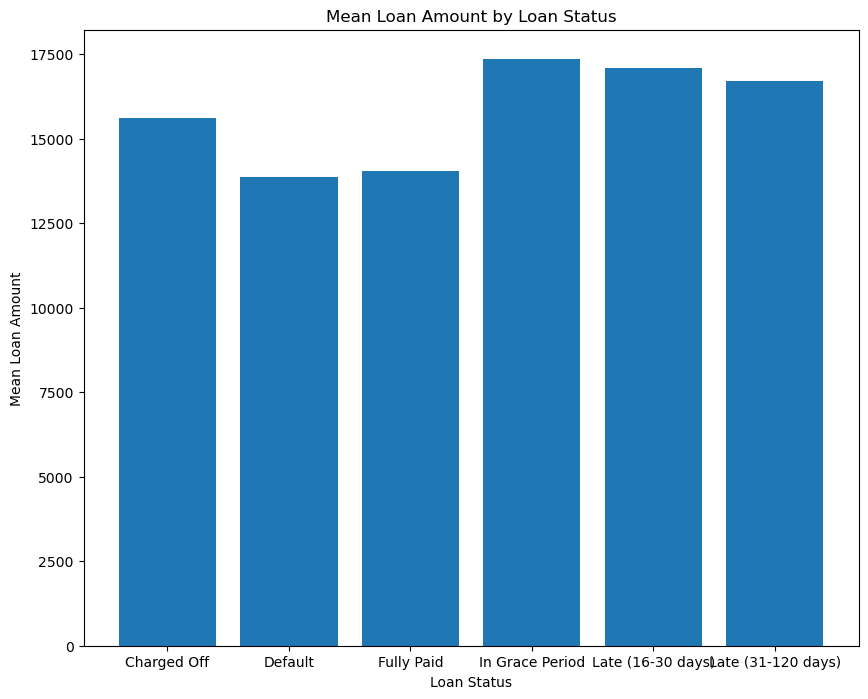

In [5]:
# Group the dataframe by loan status and calculate the mean loan amount for each group
mean_loan_amount = df.groupby('loan_status')['loan_amnt'].mean()

# Create a bar plot of the mean loan amount for each loan status
plt.figure(figsize=(10, 8))
plt.bar(mean_loan_amount.index, mean_loan_amount.values)
plt.xlabel('Loan Status')
plt.ylabel('Mean Loan Amount')
plt.title('Mean Loan Amount by Loan Status')
plt.show()

In [6]:
df.head()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,grade,sub_grade,emp_title,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,pymnt_plan,url,desc,purpose,title,zip_code,addr_state,dti,delinq_2yrs,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_d,last_pymnt_amnt,next_pymnt_d,...,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_earliest_cr_line,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,hardship_flag,hardship_type,hardship_reason,hardship_status,deferral_term,hardship_amount,hardship_start_date,hardship_end_date,payment_plan_start_date,hardship_length,hardship_dpd,hardship_loan_status,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,disbursement_method,debt_settlement_flag,debt_settlement_flag_date,settlement_status,settlement_date,settlement_amount,settlement_percentage,settlement_term
421101,130956066,NaN,3000.0,3000.0,3000.0,36 months,7.34,93.10,A,A4,Scale Technician,9 years,RENT,52000.0,Source Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,major_purchase,Major purchase,988xx,WA,0.58,0.0,Jan-1998,760.0,764.0,0.0,26.0,NaN,7.0,0.0,141.0,0.5,30.0,w,0.00,0.00,3011.577285,3011.58,3000.00,11.58,0.0,0.0,0.0,May-2018,614.03,NaN,...,1.0,7.0,0.0,0.0,0.0,1.0,96.7,0.0,0.0,0.0,191216.0,141.0,30500.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421113,130968727,NaN,5000.0,5000.0,5000.0,36 months,11.98,166.03,B,B5,SDO Supervisor,10+ years,OWN,55000.0,Not Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,other,Other,300xx,GA,14.18,0.0,Aug-2001,675.0,679.0,0.0,74.0,82.0,14.0,1.0,11449.0,33.9,24.0,w,0.00,0.00,5013.306667,5013.31,5000.00,13.31,0.0,0.0,0.0,Apr-2018,5019.97,NaN,...,3.0,14.0,0.0,0.0,0.0,2.0,95.7,33.3,1.0,0.0,61551.0,28880.0,22000.0,27751.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421120,130910225,NaN,7000.0,7000.0,7000.0,36 months,11.98,232.44,B,B5,Parole,< 1 year,MORTGAGE,40000.0,Verified,2018-03-01,Fully Paid,n,https://lendingclub.com/browse/loanDetail.acti...,NaN,home_improvement,Home improvement,797xx,TX,20.25,0.0,Mar-2007,695.0,699.0,0.0,60.0,NaN,13.0,0.0,5004.0,36.0,29.0,w,0.00,0.00,7693.314943,7693.31,7000.00,693.31,0.0,0.0,0.0,Mar-2019,5364.25,NaN,...,2.0,13.0,0.0,0.0,0.0,2.0,89.7,33.3,0.0,0.0,132817.0,131726.0,10000.0,118917.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Cash,N,NaN,NaN,NaN,NaN,NaN,NaN
421121,130962380,NaN,20300.0,20300.0,20300.0,60 months,17.47,509.66,D,D1,Administrative Assistant,< 1 year,RENT,55000.0,Verified,2018-03-01,Late (31-120 days),n,https://lendingclub.com/browse/loanDetail.acti...,NaN,credit_card,Credit card refinancing,112xx,NY,26.63,0.0,Nov-2007,705.0,709.0,0.0,NaN,NaN,10.0,0.0,17506.0,70.9,26.0,w,18497.12,18497.12,4037.880000,4037.88,1802.88,2235.00,0.0,0.0,0.0,Dec-2018,509.66,Apr-2019,...,3.0,10.0,0.0,0.0,0.0,0.0,100.0,60.0,0.0,0.0,87959.0,60594.0,24700.0,58404.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,N

In [7]:
df.info(verbose=True, show_counts=True)

<class 'pandas.core.frame.DataFrame'>
Int64Index: 521435 entries, 421101 to 2260697
Data columns (total 151 columns):
 #    Column                                      Non-Null Count   Dtype         
---   ------                                      --------------   -----         
 0    id                                          521435 non-null  object        
 1    member_id                                   0 non-null       float64       
 2    loan_amnt                                   521435 non-null  float64       
 3    funded_amnt                                 521435 non-null  float64       
 4    funded_amnt_inv                             521435 non-null  float64       
 5    term                                        521435 non-null  object        
 6    int_rate                                    521435 non-null  float64       
 7    installment                                 521435 non-null  float64       
 8    grade                                       521435 non-n

In [8]:
df.describe()

,member_id,loan_amnt,funded_amnt,funded_amnt_inv,int_rate,installment,annual_inc,dti,delinq_2yrs,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,out_prncp,out_prncp_inv,total_pymnt,total_pymnt_inv,total_rec_prncp,total_rec_int,total_rec_late_fee,recoveries,collection_recovery_fee,last_pymnt_amnt,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,policy_code,annual_inc_joint,dti_joint,acc_now_delinq,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,...,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,num_rev_tl_bal_gt_0,num_sats,num_tl_120dpd_2m,num_tl_30dpd,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,revol_bal_joint,sec_app_fico_range_low,sec_app_fico_range_high,sec_app_inq_last_6mths,sec_app_mort_acc,sec_app_open_acc,sec_app_revol_util,sec_app_open_act_il,sec_app_num_rev_accts,sec_app_chargeoff_within_12_mths,sec_app_collections_12_mths_ex_med,sec_app_mths_since_last_major_derog,deferral_term,hardship_amount,hardship_length,hardship_dpd,orig_projected_additional_accrued_interest,hardship_payoff_balance_amount,hardship_last_payment_amount,settlement_amount,settlement_percentage,settlement_term
count,0.0,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,5.214350e+05,521026.000000,521435.000000,521435.000000,521435.000000,521435.000000,265970.000000,100519.000000,521435.000000,521435.000000,5.214350e+05,521005.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,5.214350e+05,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,147559.000000,521435.0,2.884800e+04,28846.000000,521435.000000,5.214350e+05,5.214350e+05,521435.000000,521435.000000,521435.000000,521435.000000,507358.000000,5.214350e+05,450499.000000,521435.000000,521435.000000,521435.000000,521377.000000,...,521435.000000,521435.000000,515242.000000,126399.000000,474148.000000,180159.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,521435.000000,496836.000000,521435.000000,521435.000000,521435.000000,521434.000000,514815.000000,521435.000000,521435.000000,5.214350e+05,5.214350e+05,5.214350e+05,5.214350e+05,22091.000000,22092.000000,22092.000000,22092.000000,22092.000000,22092.000000,21697.000000,22092.000000,22092.000000,22092.000000,22092.000000,8103.000000,5209.0,5209.000000,5209.0,5209.000000,3660.000000,5209.000000,5209.000000,15285.000000,15285.000000,15285.000000
mean,NaN,14556.124109,14556.124109,14550.689917,13.598751,446.684784,7.864788e+04,18.846194,0.329495,697.849818,701.850014,0.587690,34.409482,71.010008,11.723904,0.243908,1.559621e+04,47.086463,24.425071,695.394657,695.251730,13299.110792,13293.968374,11248.196286,1813.082648,2.608447e+00,235.223416,40.844483,6618.560946,673.564736,654.429967,0.021938,44.482742,1.0,1.178798e+05,19.091198,0.005065,2.780180e+02,1.450149e+05,1.045411,2.788476,0.775126,1.747572,19.488633,3.589044e+04,71.436958,1.424321,3.010786,5472.979443,58.049906,...,7.486429,1.522777,22.642547,38.819935,6.547500,35.470190,0.548419,3.552059,5.457622,4.760526,7.536914,8.774118,8.236361,13.896152,5.376390,11.676872,0.000839,0.003237,0.089490,2.344112,93.903860,38.684974,0.155527,0.058792,1.810664e+05,5.157099e+04,2.274358e+04,4.515707e+04,31703.620841,663.593382,667.593382,0.776752,1.599448,11.346506,58.103646,2.984700,12.726734,0.058437,0.093473,35.889547,3.0,176.586637,3.0,14.612210,517.600328,12897.78

# Drop Columns that are empty or not available at the time of the loan.

In [10]:
# Define a list of columns to drop
cols_to_drop = ['member_id', 'desc','orig_projected_additional_accrued_interest','hardship_dpd','hardship_length',\
                'pymnt_plan','url','desc','delinq_2yrs','out_prncp','out_prncp_inv','total_pymnt','total_pymnt_inv',\
                   'total_rec_prncp','total_rec_int','total_rec_late_fee','recoveries','collection_recovery_fee',\
                    'last_pymnt_d','last_pymnt_amnt','next_pymnt_d','num_rev_tl_bal_gt_0','num_sats','num_tl_120dpd_2m',\
                        'num_tl_30dpd','num_tl_90g_dpd_24m','num_tl_op_past_12m','pct_tl_nvr_dlq','percent_bc_gt_75',\
                            'hardship_flag','hardship_type','hardship_reason','hardship_status','deferral_term',\
                                'hardship_amount','hardship_start_date','hardship_end_date','payment_plan_start_date',\
                                   'hardship_loan_status','orig_projected_additional_accrued_interest','hardship_payoff_balance_amount',\
                                    'hardship_last_payment_amount','debt_settlement_flag','debt_settlement_flag_date','settlement_status',\
                                       'settlement_date','settlement_amount','settlement_percentage','settlement_term',\
                                        'acc_now_delinq','policy_code','sec_app_fico_range_low','sec_app_fico_range_high',\
                                           'sec_app_earliest_cr_line','sec_app_inq_last_6mths','sec_app_mort_acc','sec_app_open_acc',\
                                            'sec_app_revol_util','sec_app_open_act_il','sec_app_num_rev_accts','sec_app_chargeoff_within_12_mths',\
                                               'sec_app_collections_12_mths_ex_med','sec_app_mths_since_last_major_derog','emp_title','addr_state',\
                                                'last_credit_pull_d','verification_status_joint','revol_bal_joint','dti_joint','annual_inc_joint',\
                                                   'grade','zip_code']

# Drop the columns from the DataFrame
df = df.drop(columns=cols_to_drop)

In [11]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method
421101,130956066,3000.0,3000.0,3000.0,36 months,7.34,93.10,A4,9 years,RENT,52000.0,Source Verified,2018-03-01,Fully Paid,major_purchase,Major purchase,0.58,Jan-1998,760.0,764.0,0.0,26.0,NaN,7.0,0.0,141.0,0.5,30.0,w,764.0,760.0,0.0,NaN,Individual,0.0,150592.0,0.0,0.0,1.0,2.0,7.0,0.0,NaN,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,3.0,25099.0,30359.0,0.5,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,NaN,7.0,NaN,0.0,1.0,1.0,4.0,15.0,7.0,6.0,19.0,0.0,0.0,191216.0,141.0,30500.0,0.0,Cash
421113,130968727,5000.0,5000.0,5000.0,36 months,11.98,166.03,B5,10+ years,OWN,55000.0,Not Verified,2018-03-01,Fully Paid,other,Other,14.18,Aug-2001,675.0,679.0,0.0,74.0,82.0,14.0,1.0,11449.0,33.9,24.0,w,679.0,675.0,0.0,74.0,Individual,0.0,28880.0,1.0,1.0,0.0,0.0,33.0,17431.0,63.0,2.0,2.0,4829.0,47.0,33800.0,0.0,1.0,1.0,2.0,2222.0,10551.0,52.0,0.0,0.0,77.0,199.0,3.0,3.0,0.0,3.0,NaN,12.0,NaN,1.0,3.0,3.0,4.0,7.0,6.0,13.0,18.0,1.0,0.0,61551.0,28880.0,22000.0,27751.0,Cash
421120,130910225,7000.0,7000.0,7000.0,36 months,11.98,232.44,B5,< 1 year,MORTGAGE,40000.0,Verified,2018-03-01,Fully Paid,home_improvement,Home improvement,20.25,Mar-2007,695.0,699.0,0.0,60.0,NaN,13.0,0.0,5004.0,36.0,29.0,w,644.0,640.0,0.0,60.0,Individual,0.0,131726.0,1.0,6.0,0.0,2.0,16.0,126722.0,102.0,2.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,4.0,10977.0,4996.0,50.0,0.0,0.0,122.0,132.0,1.0,1.0,0.0,10.0,64.0,5.0,60.0,3.0,2.0,2.0,3.0,4.0,19.0,7.0,10.0,0.0,0.0,132817.0,131726.0,10000.0,118917.0,Cash
421121,130962380,20300.0,20300.0,20300.0,60 months,17.47,509.66,D1,< 1 year,RENT,55000.0,Verified,2018-03-01,Late (31-120 days),credit_card,Credit card refinancing,26.63,Nov-2007,705.0,709.0,0.0,NaN,NaN,10.0,0.0,17506.0,70.9,26.0,w,704.0,700.0,0.0,NaN,Individual,0.0,60594.0,0.0,3.0,0.0,1.0,24.0,43088.0,74.0,0.0,1.0,8215.0,69.0,24700.0,0.0,1.0,0.0,3.0,6733.0,7194.0,70.9,0.0,0.0,124.0,111.0,22.0,22.0,0.0,22.0,NaN,NaN,NaN,0.0,3.0,3.0,6.0,8.0,14.0,6.0,11.0,0.0,0.0,87959.0,60594.0,24700.0,58404.0,Cash
421135,130966492,30000.0,30000.0,30000.0,36 months,21.85,1143.39,D5,10+ years,OWN,57000.0,Verified,2018-03-01,Fully Paid,debt_consolidation,Debt consolidation,27.58,Apr-2000,680.0,684.0,1.0,68.0,NaN,11.0,0.0,29222.0,53.2,26.0,w,699.0,695.0,0.0,68.0,Individual,0.0,157566.0,1.0,1.0,2.0,2.0,6.0,33030.0,94.0,2.0,2.0,6236.0,69.0,55500.0,2.0,8.0,5.0,5.0,14324.0,19752.0,33.5,0.0,0.0,195.0,215.0,11.0,6.0,2.0,11.0,NaN,0.0,NaN,1.0,3.0,4.0,6.0,7.0,10.0,9.0,14.0,0.0,0.0,188780.0,62252.0,29400.0,35000.0,Cash


In [12]:
# Calculate the proportion of missing values in each column of the DataFrame
null_rates = df.isnull().mean()

# Filter the null_rates Series to only include columns with missing values
# Sort the resulting Series in descending order to display columns with the highest null rates first
# Display the filtered and sorted null_rates Series
display(null_rates[null_rates>0].sort_values(ascending=False))

mths_since_last_record            0.807226
mths_since_recent_bc_dlq          0.757594
mths_since_last_major_derog       0.717014
mths_since_recent_revol_delinq    0.654494
mths_since_last_delinq            0.489927
il_util                           0.136040
mths_since_recent_inq             0.090686
emp_length                        0.070793
title                             0.028239
mths_since_rcnt_il                0.026997
mo_sin_old_il_acct                0.026997
bc_util                           0.013204
bc_open_to_buy                    0.012665
mths_since_recent_bc              0.011877
revol_util                        0.000825
dti                               0.000784
all_util                          0.000111
avg_cur_bal                       0.000021
dtype: float64

In [13]:
# Convert earliest_cr_line column to datetime format
df['earliest_cr_line'] = pd.to_datetime(df['earliest_cr_line'], format='%b-%Y')

# Calculate the difference in months between earliest_cr_line and issue_d
df['credit_age_months'] = (df['issue_d'] - df['earliest_cr_line']).dt.days / 30

# Check the resulting DataFrame
print(df[['earliest_cr_line', 'issue_d', 'credit_age_months']].head())

       earliest_cr_line    issue_d  credit_age_months
421101       1998-01-01 2018-03-01         245.466667
421113       2001-08-01 2018-03-01         201.866667
421120       2007-03-01 2018-03-01         133.933333
421121       2007-11-01 2018-03-01         125.766667
421135       2000-04-01 2018-03-01         218.100000


In [14]:
df.select_dtypes('object').head()

,id,term,sub_grade,emp_length,home_ownership,verification_status,loan_status,purpose,title,initial_list_status,application_type,disbursement_method
421101,130956066,36 months,A4,9 years,RENT,Source Verified,Fully Paid,major_purchase,Major purchase,w,Individual,Cash
421113,130968727,36 months,B5,10+ years,OWN,Not Verified,Fully Paid,other,Other,w,Individual,Cash
421120,130910225,36 months,B5,< 1 year,MORTGAGE,Verified,Fully Paid,home_improvement,Home improvement,w,Individual,Cash
421121,130962380,60 months,D1,< 1 year,RENT,Verified,Late (31-120 days),credit_card,Credit card refinancing,w,Individual,Cash
421135,130966492,36 months,D5,10+ years,OWN,Verified,Fully Paid,debt_consolidation,Debt consolidation,w,Individual,Cash


In [15]:
df['loan_status'].value_counts()

Fully Paid            379514
Charged Off           110795
Late (31-120 days)     19551
In Grace Period         7566
Late (16-30 days)       3971
Default                   38
Name: loan_status, dtype: int64

In [16]:
df['emp_length'].value_counts()

10+ years    173392
2 years       48285
< 1 year      42772
3 years       42420
1 year        35277
5 years       32108
4 years       31752
6 years       22603
8 years       19440
9 years       18612
7 years       17860
Name: emp_length, dtype: int64

In [17]:
df['term'].value_counts()

 36 months    399335
 60 months    122100
Name: term, dtype: int64

<Axes: title={'center': 'Loan Status Counts'}, xlabel='Loan Status', ylabel='Count'>

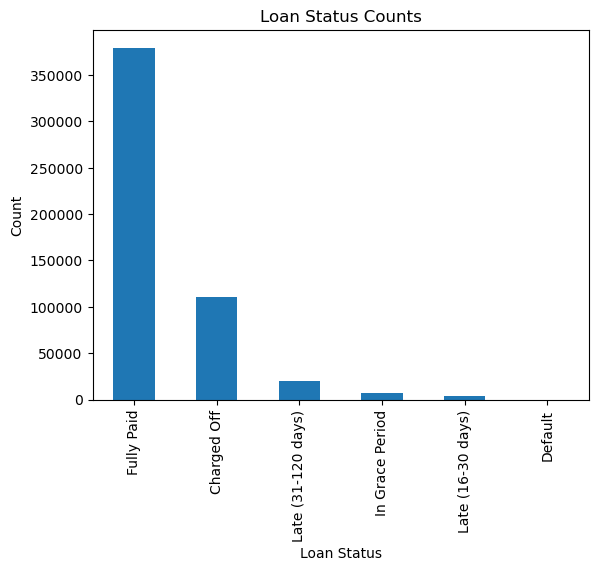

In [18]:
df['loan_status'].value_counts().plot(kind='bar',
    title="Loan Status Counts", xlabel='Loan Status', ylabel='Count'
)

In [19]:
plt.figure(figsize=(100, 100))
sns.heatmap(df.corr(), annot=True, cmap='viridis')

C:\Users\Jonat\AppData\Local\Temp\ipykernel_13588\804933972.py:2: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr(), annot=True, cmap='viridis')


<Axes: >

In [20]:
df.groupby(by='loan_status')['loan_amnt'].describe()

,count,mean,std,min,25%,50%,75%,max
loan_status,,,,,,,,
Charged Off,110795.0,15617.559908,9315.534726,1000.0,8000.0,14000.0,21000.0,40000.0
Default,38.0,13869.078947,10021.477669,1675.0,5625.0,10000.0,20000.0,40000.0
Fully Paid,379514.0,14053.541371,9196.064431,1000.0,7000.0,12000.0,20000.0,40000.0
In Grace Period,7566.0,17352.375760,9932.085852,1000.0,10000.0,15000.0,24000.0,40000.0
Late (16-30 days),3971.0,17086.036263,10153.490354,1000.0,10000.0,15000.0,24000.0,40000.0
Late (31-120 days),19551.0,16702.244131,9815.676367,1000.0,9600.0,15000.0,24000.0,40000.0


In [21]:
# Filter DataFrame to include only current loans
df.loc[df['loan_status'] == 'Current']


,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,credit_age_months


In [22]:
# Define a function to encode the loan status
def encode_loan_status(status):
    if status == 'Fully Paid':
        return 0
    elif status in ['Charged Off', 'Default']:
        return 1
    elif status in ['Late (31-120 days)', 'Late (16-30 days)', 'In Grace Period']:
        return 1
    else:
        return None

# Create a new column with the encoded loan status
df['loan_status_encoded'] = df['loan_status'].apply(encode_loan_status)

# Check the value counts for the encoded loan status
print(df['loan_status_encoded'].value_counts())

0    379514
1    141921
Name: loan_status_encoded, dtype: int64


In [23]:
# Replace missing emp_length values with '0 years'
df['emp_length'].fillna('0 years', inplace=True)

In [24]:
# Define a function to extract the numerical value from emp_length
def extract_years(s):
    if pd.isnull(s):
        return 0
    else:
        years = re.search(r'\d+', s).group()
        return int(years)

# Apply the extract_years function to the emp_length column
df['emp_length_years'] = df['emp_length'].apply(extract_years)

In [25]:
# Fill missing values in 'mths_since_last_delinq' with a large number
# This is done because missing values in this column likely indicate that the borrower has not had a delinquency in the past, and so we assign a value greater than the maximum value in the column to these missing values
max_val = df['mths_since_last_delinq'].max()
df['mths_since_last_delinq'].fillna(max_val + 1, inplace=True)

# Fill missing values in 'mths_since_last_record' with 0
# This is done because missing values in this column likely indicate that the borrower has not had a public record or derogatory mark on their credit report, and so we assign 0 to these missing values
max_val = df['mths_since_last_record'].max()
df['mths_since_last_record'].fillna(max_val + 1, inplace=True)

# Fill missing values in 'mths_since_recent_bc_dlq' with 0
max_val = df['mths_since_recent_bc_dlq'].max()
df['mths_since_recent_bc_dlq'].fillna(max_val + 1, inplace=True)

# Fill missing values in 'mths_since_last_major_derog' with 0
max_val = df['mths_since_last_major_derog'].max()
df['mths_since_last_major_derog'].fillna(max_val + 1, inplace=True)

# Fill missing values in 'mths_since_recent_revol_delinq' with 0
max_val = df['mths_since_recent_revol_delinq'].max()
df['mths_since_recent_revol_delinq'].fillna(max_val + 1, inplace=True)

# Fill missing values in 'il_util' with 0
df['il_util'].fillna(0, inplace=True)

# Fill missing values in 'bc_open_to_buy' with 0
df['bc_open_to_buy'].fillna(0, inplace=True)

# Fill missing values in 'bc_util' with 0
df['bc_util'].fillna(0, inplace=True)

# Fill missing values in 'revol_util' with 100
# This is done because the 'revol_util' column represents the borrower's revolving line utilization rate as a percentage, and so missing values in this column likely indicate that the borrower has not used any of their revolving credit lines
df['revol_util'].fillna(100, inplace=True)

# Fill missing values in 'dti' with 0
df['dti'].fillna(0, inplace=True)

# Fill missing values in 'all_util' with 0
df['all_util'].fillna(0, inplace=True)

# Fill missing values in the 'title' column with the string 'None'
# This is done because the 'title' column represents the loan title provided by the borrower, and some borrowers may not provide a title or may provide an incomplete or invalid title
# Filling missing values with the string 'None' allows us to distinguish between loans where the borrower did not provide a title and loans where a title was provided but the value was missing or invalid
df['title'] = df['title'].fillna('None')

In [27]:
df.head()

,id,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,sub_grade,emp_length,home_ownership,annual_inc,verification_status,issue_d,loan_status,purpose,title,dti,earliest_cr_line,fico_range_low,fico_range_high,inq_last_6mths,mths_since_last_delinq,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,initial_list_status,last_fico_range_high,last_fico_range_low,collections_12_mths_ex_med,mths_since_last_major_derog,application_type,tot_coll_amt,tot_cur_bal,open_acc_6m,open_act_il,open_il_12m,open_il_24m,mths_since_rcnt_il,total_bal_il,il_util,open_rv_12m,open_rv_24m,max_bal_bc,all_util,total_rev_hi_lim,inq_fi,total_cu_tl,inq_last_12m,acc_open_past_24mths,avg_cur_bal,bc_open_to_buy,bc_util,chargeoff_within_12_mths,delinq_amnt,mo_sin_old_il_acct,mo_sin_old_rev_tl_op,mo_sin_rcnt_rev_tl_op,mo_sin_rcnt_tl,mort_acc,mths_since_recent_bc,mths_since_recent_bc_dlq,mths_since_recent_inq,mths_since_recent_revol_delinq,num_accts_ever_120_pd,num_actv_bc_tl,num_actv_rev_tl,num_bc_sats,num_bc_tl,num_il_tl,num_op_rev_tl,num_rev_accts,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit,disbursement_method,credit_age_months,loan_status_encoded,emp_length_years
421101,130956066,3000.0,3000.0,3000.0,36 months,7.34,93.10,A4,9 years,RENT,52000.0,Source Verified,2018-03-01,Fully Paid,major_purchase,Major purchase,0.58,1998-01-01,760.0,764.0,0.0,26.0,0.0,7.0,0.0,141.0,0.5,30.0,w,764.0,760.0,0.0,0.0,Individual,0.0,150592.0,0.0,0.0,1.0,2.0,7.0,0.0,0.0,0.0,1.0,141.0,1.0,31000.0,1.0,2.0,2.0,3.0,25099.0,30359.0,0.5,0.0,0.0,132.0,242.0,18.0,7.0,4.0,18.0,0.0,7.0,0.0,0.0,1.0,1.0,4.0,15.0,7.0,6.0,19.0,0.0,0.0,191216.0,141.0,30500.0,0.0,Cash,245.466667,0,9
421113,130968727,5000.0,5000.0,5000.0,36 months,11.98,166.03,B5,10+ years,OWN,55000.0,Not Verified,2018-03-01,Fully Paid,other,Other,14.18,2001-08-01,675.0,679.0,0.0,74.0,82.0,14.0,1.0,11449.0,33.9,24.0,w,679.0,675.0,0.0,74.0,Individual,0.0,28880.0,1.0,1.0,0.0,0.0,33.0,17431.0,63.0,2.0,2.0,4829.0,47.0,33800.0,0.0,1.0,1.0,2.0,2222.0,10551.0,52.0,0.0,0.0,77.0,199.0,3.0,3.0,0.0,3.0,0.0,12.0,0.0,1.0,3.0,3.0,4.0,7.0,6.0,13.0,18.0,1.0,0.0,61551.0,28880.0,22000.0,27751.0,Cash,201.866667,0,10
421120,130910225,7000.0,7000.0,7000.0,36 months,11.98,232.44,B5,< 1 year,MORTGAGE,40000.0,Verified,2018-03-01,Fully Paid,home_improvement,Home improvement,20.25,2007-03-01,695.0,699.0,0.0,60.0,0.0,13.0,0.0,5004.0,36.0,29.0,w,644.0,640.0,0.0,60.0,Individual,0.0,131726.0,1.0,6.0,0.0,2.0,16.0,126722.0,102.0,2.0,2.0,3944.0,90.0,13900.0,2.0,1.0,4.0,4.0,10977.0,4996.0,50.0,0.0,0.0,122.0,132.0,1.0,1.0,0.0,10.0,64.0,5.0,60.0,3.0,2.0,2.0,3.0,4.0,19.0,7.0,10.0,0.0,0.0,132817.0,131726.0,10000.0,118917.0,Cash,133.933333,0,1
421121,130962380,20300.0,20300.0,20300.0,60 months,17.47,509.66,D1,< 1 year,RENT,55000.0,Verified,2018-03-01,Late (31-120 days),credit_card,Credit card refinancing,26.63,2007-11-01,705.0,709.0,0.0,227.0,0.0,10.0,0.0,17506.0,70.9,26.0,w,704.0,700.0,0.0,0.0,Individual,0.0,60594.0,0.0,3.0,0.0,1.0,24.0,43088.0,74.0,0.0,1.0,8215.0,69.0,24700.0,0.0,1.0,0.0,3.0,6733.0,7194.0,70.9,0.0,0.0,124.0,111.0,22.0,22.0,0.0,22.0,0.0,NaN,0.0,0.0,3.0,3.0,6.0,8.0,14.0,6.0,11.0,0.0,0.0,87959.0,60594.0,24700.0,58404.0,Cash,125.766667,1,1
421135,130966492,30000.0,30000.0,30000.0,36 months,21.85,1143.39,D5,10+ years,OWN,57000.0,Verified,2018-03-01,Fully Paid,debt_consolidation,Debt consolidation,27.58,2000-04-01,680.0,684.0,1.0,68.0,0.0,11.0,0.0,29222.0,53.2,26.0,w,699.0,695.0,0.0,68.0,Individual,0.0,157566.0,1.0,1.0,2.0,2.0,6.0,33030.0,94.0,2.0,2.0,6236.0,69.0,55500.0,2.0,8.0,5.0,5.0,14324.0,19752.0,33.5,0.0,0.0,195.0,215.0,11.0,6.0,2.0,11.0,0.0,0.0,0.0,1.0,3.0,4.0,6.0,7.0,10.0,9.0,14.0,0.0,0.0,188780.0,62252.0,29400.0,35000.0,Cash,218.100000,0,10


In [28]:
# Assuming `df` is the DataFrame containing the `loan_status_encoded` column
value_counts = df['loan_status_encoded'].value_counts(normalize=True)

# Print the percentage of each value
for value, percentage in value_counts.items():
    print(f"{value}: {percentage:.2%}")

0: 72.78%
1: 27.22%


# Train-Test Split

In [29]:
#Reduce Data for testing purposes
#df = df.sample(frac=0.5, random_state=42)

In [30]:
# Define target variable and feature set
target = 'loan_status_encoded'

# Split data into train and test sets
X_train, X_test, y_train, y_test = train_test_split(df.drop([target, 'id','term','purpose','earliest_cr_line','issue_d','loan_status','emp_length',\
                                                             'mths_since_rcnt_il','mo_sin_old_il_acct','mths_since_recent_inq','mths_since_recent_bc'], axis=1),\
                                                    df[target], test_size=0.5, random_state=42)

# Check the shape of the resulting data sets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")

X_train shape: (130359, 72)
X_test shape: (130359, 72)


In [31]:
X_train.select_dtypes('object').info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 130359 entries, 736177 to 481531
Data columns (total 7 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   sub_grade            130359 non-null  object
 1   home_ownership       130359 non-null  object
 2   verification_status  130359 non-null  object
 3   title                130359 non-null  object
 4   initial_list_status  130359 non-null  object
 5   application_type     130359 non-null  object
 6   disbursement_method  130359 non-null  object
dtypes: object(7)
memory usage: 8.0+ MB


In [32]:
# Define the columns that need one-hot encoding and ordinal encoding
# Nominal columns are columns that have no inherent order or ranking, and so we need to use one-hot encoding to represent the different categories as binary features
# Ordinal columns are columns that have a natural order or ranking, and so we need to use ordinal encoding to represent the different categories as ordered numerical values
nominal_cols = ['home_ownership', 'verification_status', 'title', 'initial_list_status', 'application_type', 'disbursement_method']
ordinal_cols = ['sub_grade']

# Define the categories for the 'sub_grade' column
# The 'sub_grade' column represents a loan's sub-grade, which is a more specific indicator of creditworthiness than the overall grade assigned to the loan
# The sub-grades are ordered from highest to lowest creditworthiness, so we use a list of the sub-grades in order to define the categories for ordinal encoding
sub_grade_categories = [['G5', 'G4', 'G3', 'G2', 'G1', 'F5', 'F4', 'F3', 'F2', 'F1', 'E5', 'E4', 'E3', 'E2', 'E1', 'D5', 'D4', 'D3', 'D2', 'D1', 'C5', 'C4', 'C3', 'C2', 'C1', 'B5', 'B4', 'B3', 'B2', 'B1', 'A5', 'A4', 'A3', 'A2', 'A1']]


In [34]:
# Check for records in sub_grade not in sub_grade_categories
sub_grade_values = df['sub_grade'].unique()
missing_sub_grades = set(sub_grade_values) - set(sub_grade_categories[0])
if missing_sub_grades:
    print('Sub-grades not in category list:', missing_sub_grades)

In [35]:
# Define a ColumnTransformer to apply different transformations to different columns of the input data
# We use SimpleImputer with 'mean' strategy to fill missing values in numerical columns with the mean of the column
# We use OneHotEncoder to perform one-hot encoding on nominal columns
# We use OrdinalEncoder to perform ordinal encoding on the 'sub_grade' column using the defined categories
# We use SimpleImputer with 'mean' strategy to fill missing values in the 'emp_length_years' column with the mean of the column
transformer = ColumnTransformer(
    transformers=[
       ('num', SimpleImputer(strategy='mean'), [col for col in X_train.columns if col not in nominal_cols+ordinal_cols]),
       ('nom', OneHotEncoder(handle_unknown='ignore'), nominal_cols),
       ('ord1', OrdinalEncoder(categories=sub_grade_categories), ['sub_grade']),
       ('fill_emp_length', SimpleImputer(strategy='mean'), ['emp_length_years']),
    ])


In [36]:
# Create the pipeline with the column transformer and the logistic regression estimator
pipeline = Pipeline([
    ('transformer', transformer),
    ('classifier', LogisticRegression(max_iter=1000))
])

In [37]:
# Perform cross-validation and print the results
# scores = cross_val_score(pipeline, X_train, y_train, cv=5, n_jobs=-1)
# print('Cross-validation scores:', scores)
# print('Mean score:', scores.mean())

In [38]:
null_rates = X_train.isnull().mean()
display(null_rates[null_rates>0].sort_values(ascending=False))

avg_cur_bal    0.000015
dtype: float64

In [39]:
# Define three pipelines to train three different classifiers using the same preprocessing steps
# All three pipelines use the same ColumnTransformer to apply the same preprocessing steps to the input data
# All three pipelines use SMOTEENN to address class imbalance by oversampling the minority class and undersampling the majority class
# All three pipelines use StandardScaler to standardize the features to have zero mean and unit variance
# The first pipeline uses a RandomForestClassifier as the classifier
# The second pipeline uses a KNeighborsClassifier as the classifier
# The third pipeline uses a LogisticRegression as the classifier with a maximum iteration of 2000 to ensure convergence
rf_pipeline = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', RandomForestClassifier())
])

knn_pipeline = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', KNeighborsClassifier())
])

logreg_pipeline = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', LogisticRegression(max_iter=2000))
])


In [40]:
# Define parameter grids for each pipeline to search over during hyperparameter tuning
# The first parameter grid defines hyperparameters for a RandomForestClassifier
# The second parameter grid defines hyperparameters for a KNeighborsClassifier
# The third parameter grid defines hyperparameters for a LogisticRegression
# All three parameter grids include a sampling strategy parameter for SMOTEENN to address class imbalance
# The first parameter grid includes hyperparameters for the number of trees in the forest, maximum depth of the tree, minimum samples to split, minimum samples per leaf, and the maximum number of features to consider when looking for the best split
# The second parameter grid includes hyperparameters for the number of neighbors, weighting function, and the algorithm to use when computing the nearest neighbors
# The third parameter grid includes hyperparameters for the regularization strength, type of regularization penalty, optimization algorithm, and the type of multi-class classification to perform
rf_param_grid = {
    'classifier__n_estimators': [10, 100, 1000],
    'classifier__max_depth': [5, 10, None],
    'classifier__min_samples_split': [2, 5, 10],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': ['sqrt', 'log2'],
    'sampling__sampling_strategy': ['minority', 'not majority']
}

knn_param_grid = {
    'classifier__n_neighbors': [3, 5, 7],
    'classifier__weights': ['uniform', 'distance'],
    'classifier__algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute'],
    'sampling__sampling_strategy': ['minority', 'not majority']
}

logreg_param_grid = {
    'sampling__sampling_strategy': ['minority', 'not majority'],
    'classifier__C': [0.001, 0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear', 'saga'],
    'classifier__multi_class': ['auto', 'ovr', 'multinomial']
}


In [41]:
scoring = ['f1', 'precision', 'recall', 'roc_auc']

In [42]:
# # Perform the grid search for each classifier
# rf_grid_search = GridSearchCV(rf_pipeline, param_grid=rf_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
# rf_grid_search.fit(X_train, y_train)

# knn_grid_search = GridSearchCV(knn_pipeline, param_grid=knn_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
# knn_grid_search.fit(X_train, y_train)

# logreg_grid_search = GridSearchCV(logreg_pipeline, param_grid=logreg_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
# logreg_grid_search.fit(X_train, y_train)

In [43]:
# Print the best parameters and results for Random Forest
# print("Random Forest best parameters:", rf_grid_search.best_params_)
# print("Random Forest best train score:", rf_grid_search.best_score_)
# print("Random Forest test score:", rf_grid_search.score(X_test, y_test))
# print("Random Forest train score:", rf_grid_search.cv_results_['mean_train_score'][rf_grid_search.best_index_])

# # Print the best parameters and results for k-Nearest Neighbors
# print("k-Nearest Neighbors best parameters:", knn_grid_search.best_params_)
# print("k-Nearest Neighbors best train score:", knn_grid_search.best_score_)
# print("k-Nearest Neighbors test score:", knn_grid_search.score(X_test, y_test))
# print("k-Nearest Neighbors train score:", knn_grid_search.cv_results_['mean_train_score'][knn_grid_search.best_index_])

# # Print the best parameters and results for Logistic Regression
# print("Logistic Regression best parameters:", logreg_grid_search.best_params_)
# print("Logistic Regression best train score:", logreg_grid_search.best_score_)
# print("Logistic Regression test score:", logreg_grid_search.score(X_test, y_test))
# print("Logistic Regression train score:", logreg_grid_search.cv_results_['mean_train_score'][logreg_grid_search.best_index_])


Random Forest best parameters: {'classifier__max_depth': None, 'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 2, 'classifier__min_samples_split': 2, 'classifier__n_estimators': 1000, 'sampling__sampling_strategy': 'not majority'}

Random Forest best train score: 0.9389487916215391

Random Forest test score: 0.9399051452109669

Random Forest train score: 0.9696959464608869

k-Nearest Neighbors best parameters: {'classifier__algorithm': 'auto', 'classifier__n_neighbors': 7, 'classifier__weights': 'distance', 'sampling__sampling_strategy': 'minority'}

k-Nearest Neighbors best train score: 0.7668199862177116

k-Nearest Neighbors test score: 0.7773502069043705

k-Nearest Neighbors train score: 0.9043360531630107

Logistic Regression best parameters: {'classifier__C': 0.01, 'classifier__multi_class': 'multinomial', 'classifier__penalty': 'l1', 'classifier__solver': 'saga', 'sampling__sampling_strategy': 'minority'}

Logistic Regression best train score: 0.9450411523563019

Logistic Regression test score: 0.9464289628327949

Logistic Regression train score: 0.9460476109259849

In [44]:
from sklearn.metrics import confusion_matrix

# # Evaluate best model on test set
# best_models = [rf_grid_search.best_estimator_, knn_grid_search.best_estimator_, logreg_grid_search.best_estimator_]
# model_names = ['RandomForestClassifier', 'KNeighborsClassifier', 'LogisticRegression']

# for model, name in zip(best_models, model_names):
#     print(f"{name}:")
#     y_pred = model.predict(X_test)
#     print(classification_report(y_test, y_pred))
#     print("Confusion Matrix:")
#     print(confusion_matrix(y_test, y_pred))
#     print('--------------------------')

RandomForestClassifier:
              precision    recall  f1-score   support

           0       0.95      0.91      0.93      3835
           1       0.78      0.88      0.82      1380

    accuracy                           0.90      5215
   macro avg       0.86      0.89      0.88      5215
weighted avg       0.91      0.90      0.90      5215

Confusion Matrix:
[[3487  348]
 [ 172 1208]]
--------------------------
KNeighborsClassifier:
              precision    recall  f1-score   support

           0       0.93      0.45      0.60      3835
           1       0.37      0.90      0.52      1380

    accuracy                           0.57      5215
   macro avg       0.65      0.67      0.56      5215
weighted avg       0.78      0.57      0.58      5215

Confusion Matrix:
[[1710 2125]
 [ 136 1244]]
--------------------------
LogisticRegression:
              precision    recall  f1-score   support

           0       0.96      0.85      0.90      3835
           1       0.69      0.91      0.78      1380

    accuracy                           0.87      5215
   macro avg       0.82      0.88      0.84      5215
weighted avg       0.89      0.87      0.87      5215

Confusion Matrix:
[[3259  576]
 [ 123 1257]]
--------------------------

In [45]:
xgb_pipeline = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier())
])

xgb_param_grid = {
    'classifier__n_estimators': [100, 500, 1000],
    'classifier__learning_rate': [0.01, 0.1, 1],
    'classifier__max_depth': [3, 5, 7],
    'sampling__sampling_strategy': ['minority', 'not majority']
}

xgb_grid_search = GridSearchCV(xgb_pipeline, param_grid=xgb_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
xgb_grid_search.fit(X_train, y_train)

In [46]:
# Print the best parameters and results for XGBoost
# print("XGBoost best parameters:", xgb_grid_search.best_params_)
# print("XGBoost best train score:", xgb_grid_search.best_score_)
# print("XGBoost test score:", xgb_grid_search.score(X_test, y_test))
# print("XGBoost train score:", xgb_grid_search.cv_results_['mean_train_score'][xgb_grid_search.best_index_])

XGBoost best parameters: {'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__n_estimators': 1000, 'sampling__sampling_strategy': 'minority'}

XGBoost best train score: 0.9448052748785258

XGBoost test score: 0.9448366494718743

XGBoost train score: 0.9524318950373661

In [47]:
from sklearn.pipeline import make_pipeline
from sklearn.ensemble import StackingClassifier

# # Create the final pipeline with the stacked model
stacking_pipeline = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTEENN(random_state=42)),
    ('scaler', StandardScaler()),
    ('stack', StackingClassifier(estimators=[
        ('rf', RandomForestClassifier(max_depth=None, max_features='sqrt', min_samples_leaf=2, min_samples_split=2, n_estimators=1000)),
        ('xgb', XGBClassifier(learning_rate=0.01, max_depth=3, n_estimators=1000))
    ], final_estimator=LogisticRegression()))
])

# # Define the hyperparameter grid for the stacked model
# stacking_param_grid = {
#     'stack__final_estimator__C': [0.01, 0.1, 1],
#     'stack__final_estimator__penalty': ['l1', 'l2'],
#     'stack__final_estimator__solver': ['liblinear', 'saga'],
#     'sampling__sampling_strategy': ['minority', 'not majority']
# }

# # Perform the grid search for the stacked model
# stacking_grid_search = GridSearchCV(stacking_pipeline, param_grid=stacking_param_grid, cv=5, scoring='roc_auc', n_jobs=-1, return_train_score=True)
# stacking_grid_search.fit(X_train, y_train)

# # Print the best parameters and results for the stacked model
# print("Stacked Model best parameters:", stacking_grid_search.best_params_)
# print("Stacked Model best train score:", stacking_grid_search.best_score_)
# print("Stacked Model test score:", stacking_grid_search.score(X_test, y_test))
# print("Stacked Model train score:", stacking_grid_search.cv_results_['mean_train_score'][stacking_grid_search.best_index_])

Stacked Model best parameters: {'sampling__sampling_strategy': 'minority', 'stack__final_estimator__C': 0.01, 'stack__final_estimator__penalty': 'l1', 'stack__final_estimator__solver': 'liblinear'}
Stacked Model best train score: 0.9437983890905718
Stacked Model test score: 0.9436447291347808
Stacked Model train score: 0.9644802340751542

In [48]:
# Define the pipeline with the SMOTE-ENN, the transformer, the StandardScaler, and the XGBoostClassifier
xgb_pipeline_final = Pipeline([
    ('transformer', transformer),
    ('sampling', SMOTEENN(sampling_strategy='minority', random_state=42)),
    ('scaler', StandardScaler()),
    ('classifier', XGBClassifier(n_estimators=1000, max_depth=3, learning_rate=0.01,tree_method='hist' ,enable_categorical=True))
])

In [49]:
# Define the pipeline with the SMOTE-ENN, the transformer, the StandardScaler, and the RandomForestClassifier
# rf_pipeline_final = Pipeline([
#     ('transformer', transformer),
#     ('sampling', SMOTEENN(sampling_strategy='not majority', random_state=42)),
#     ('scaler', StandardScaler()),
#     ('classifier', RandomForestClassifier(n_estimators=1000, max_depth=None, max_features='sqrt',
#                                            min_samples_leaf=2, min_samples_split=2))
# ])

In [50]:
# Train the pipeline on the full dataset
xgb_pipeline_final.fit(X_train, y_train)

# Predict the target variable for the test set
y_pred = xgb_pipeline_final.predict(X_test)

In [51]:
# Train the pipeline on the full dataset
# rf_pipeline_final.fit(X_train, y_train)

# Predict the target variable for the test set
# y_pred = rf_pipeline_final.predict(X_test)

In [52]:
# Compute and print the accuracy, recall, precision, and F1 score for the test set
accuracy = accuracy_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
f1 = f1_score(y_test, y_pred)

print("Accuracy: {:.2f}%".format(accuracy * 100))
print("Recall: {:.2f}%".format(recall * 100))
print("Precision: {:.2f}%".format(precision * 100))
print("F1 score: {:.2f}%".format(f1 * 100))

Accuracy: 90.38%
Recall: 86.91%
Precision: 79.45%
F1 score: 83.01%


XGBoost Numbers
Accuracy: 90.26%
Recall: 87.17%
Precision: 79.07%
F1 score: 82.92%

<Figure size 1600x1200 with 0 Axes>

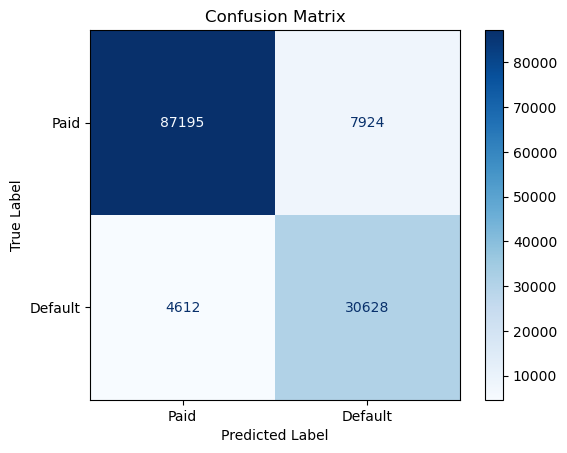

In [53]:
# Compute the confusion matrix
cm = confusion_matrix(y_test, y_pred, labels=xgb_pipeline_final.classes_)

# Create a larger plot for the confusion matrix
plt.figure(figsize=(16, 12))

# Plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Paid', 'Default'])
disp.plot(cmap='Blues')

# Add labels and title
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')

plt.show()

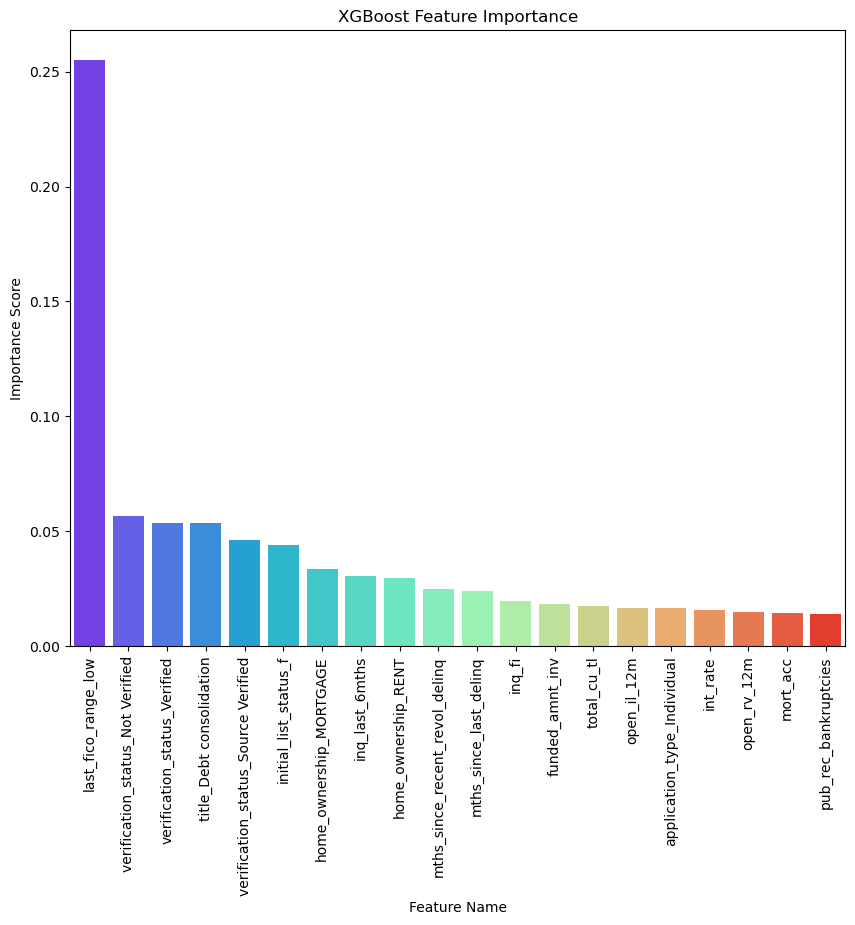

In [58]:
# Get the feature importance scores from the XGBoost model
importance_scores = xgb_pipeline_final.named_steps['classifier'].feature_importances_

# Get the feature names from the column transformer
feature_names = []
for transformer_in_columns in xgb_pipeline_final.named_steps['transformer'].transformers_:
    # Check if transformer is the one-hot encoder or ordinal encoder
    if transformer_in_columns[0] in ['nom', 'ord1']:
        # Get the feature names using get_feature_names_out() method
        feature_names += list(transformer_in_columns[1].get_feature_names_out())
    # Check if transformer is the numerical transformer
    elif transformer_in_columns[0] == 'num':
        # Get the numerical feature names from the original feature columns
        feature_names += transformer_in_columns[2]
        
# Create a dictionary that maps feature names to importance scores
feature_importance = dict(zip(feature_names, importance_scores))

# Sort the dictionary by importance score in descending order
sorted_importance = {k: v for k, v in sorted(feature_importance.items(), key=lambda item: item[1], reverse=True)}

# Create a bar plot of the top 20 features
top_k = 20
plt.figure(figsize=(10, 8))
sns.barplot(x=list(sorted_importance.keys())[:top_k], y=list(sorted_importance.values())[:top_k], palette='rainbow')
plt.xticks(rotation=90)
plt.xlabel('Feature Name')
plt.ylabel('Importance Score')
plt.title('XGBoost Feature Importance')
plt.show()

<Figure size 1600x1200 with 0 Axes>

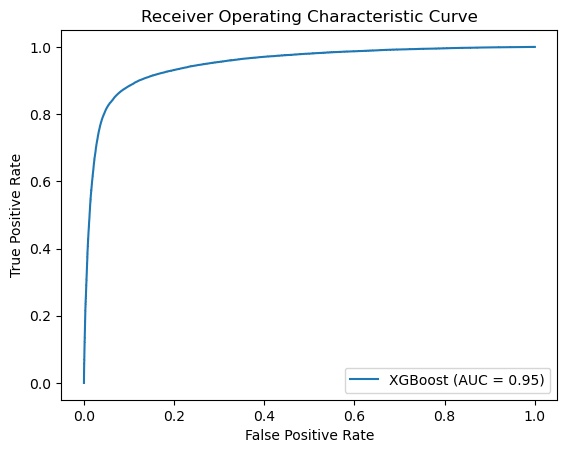

In [55]:
# Compute the ROC curve
y_score = xgb_pipeline_final.predict_proba(X_test)[:, 1]
fpr, tpr, _ = roc_curve(y_test, y_score)
roc_auc = roc_auc_score(y_test, y_score)

# Create a larger plot for the ROC curve
plt.figure(figsize=(16, 12))

# Plot the ROC curve
roc_display = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='XGBoost')
roc_display.plot()

# Add labels and legend
plt.title('Receiver Operating Characteristic Curve')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc='lower right')

plt.show()

In [56]:
# Compute the learning curve and plot it
# train_sizes, train_scores, test_scores = learning_curve(xgb_pipeline_final, X_test, y_test, cv=5, scoring='roc_auc', n_jobs=-1)
# train_mean = np.mean(train_scores, axis=1)
# train_std = np.std(train_scores, axis=1)
# test_mean = np.mean(test_scores, axis=1)
# test_std = np.std(test_scores, axis=1)
# plt.figure(figsize=(16, 12))
# plt.figure()
# plt.title('Learning Curve')
# plt.xlabel('Training examples')
# plt.ylabel('Score')
# plt.ylim(0.9, 1.0)
# plt.grid()
# plt.fill_between(train_sizes, train_mean - train_std, train_mean + train_std, alpha=0.1, color='r')
# plt.fill_between(train_sizes, test_mean - test_std, test_mean + test_std, alpha=0.1, color='g')
# plt.plot(train_sizes, train_mean, 'o-', color='r', label='Training score')
# plt.plot(train_sizes, test_mean, 'o-', color='g', label='Cross-validation score')
# plt.legend(loc='best')
# plt.show()

### Predicting Loan Default with XGBoost and SMOTE-ENN
# Conclusion
Lending Club approves about 100,000 loans per year, of which 27,000 (27%) default on average, resulting in a loss of 75% of the loan amount for each defaulting loan. This means that Lending Club loses a total of $283,424,500 per year due to loan defaults.

Our XGBoost model trained on Lending Club's historical loan data with SMOTE-ENN oversampling and feature engineering techniques can potentially reduce the number of defaulting loans to 5,000, which would bring the default rate down to 5%. This means that Lending Club would only lose $54,585,000 per year due to loan defaults.

The potential cost savings for Lending Club can be estimated as the difference between the original loss due to loan defaults and the adjusted loss based on our model. This means that our model can potentially save Lending Club around $228,839,500 per year.

We acknowledge that our analysis ignores the potential profits from loans that our model would have denied even though they paid off their loans. However, we believe that the cost savings from reducing loan defaults can still have a significant impact on Lending Club's financial performance and sustainability.

We recommend further testing and validation of our model using more recent data and additional evaluation metrics, as well as collaboration with Lending Club's data and risk management teams to ensure the model's feasibility and compatibility with their business operations.